# Description

We already have prepared data to applying clustering algorithm. We are going to use one of the most common algorithms - Kmeans. Because it needs only one parametrs - number of clusters (for example DBSCAN needs two parametrs) and pretty well works with a large data (for example aglomerative clustering works slow in large data).

# Import libraries

In [17]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap
import joblib

plt.style.use('ggplot')
plt.close('all')

In [2]:
# This is done to avoid seeing warnings in Jupyter Notebook

import warnings
warnings.filterwarnings('ignore')

# Load the preprocessed data

In [3]:
df = pd.read_csv('../data/preprocessed_data.csv')

In [4]:
# check the data

df.head(3)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,title,overview
0,0.017633,-0.007924,-0.015550,0.000302,0.000365,-0.022049,0.002591,-0.008464,-0.010561,0.002480,...,-0.001091,0.008336,0.004997,0.005294,0.004412,0.008469,0.000249,-0.009911,Toy Story,"['led', 'woodi', 'andi', 'toy', 'live', 'happi..."
1,0.001098,-0.027537,-0.040712,0.044191,0.015212,0.030396,0.029333,0.035673,-0.005655,0.020995,...,0.031742,-0.003428,-0.026673,-0.005241,-0.027287,-0.014400,-0.029571,-0.021927,Jumanji,"['sibl', 'judi', 'peter', 'discov', 'enchant',..."
2,-0.005981,-0.017038,-0.026429,0.009457,-0.029082,-0.052522,-0.026780,-0.027246,-0.020376,0.003065,...,-0.015675,0.011839,0.007691,0.014303,-0.018292,-0.013140,-0.004403,-0.008304,Grumpier Old Men,"['famili', 'wed', 'reignit', 'ancient', 'feud'..."


In [5]:
# leave numeric columns for training model

X = df.drop(columns=['title', 'overview'])

# Getting of optimal number of clusters

We are going to use Kmeans, so we need to get optimal k - number of clusters. We are going to use two basics methods - elbow method and silhouette score. 

In [6]:
num_clusters = np.arange( 1, 101, 1 )

inertias = []
silhouette_scores = []

for cluster in num_clusters:

    kmeans = KMeans(n_clusters=cluster)
    labels = kmeans.fit_predict(X)

    inertias.append( kmeans.inertia_ )


    if cluster > 1:

        # create data sampling for compute silhouette score 

        sample_idx = np.random.choice(X.shape[0], size=10000, replace=False) 
        X_sample = X.iloc[ sample_idx, : ]
        labels_sample = labels[ sample_idx ]

        silhouette_scores.append( silhouette_score( X_sample, labels_sample ) )


So we have computed inertia and silhouette score for n_clusters = 1 ... 100 (for silhouette score we start from 2 clusters). We have computed silhouette score not for whole dataset but for sample with size=10000 because for the entire dataset it would take much longer.

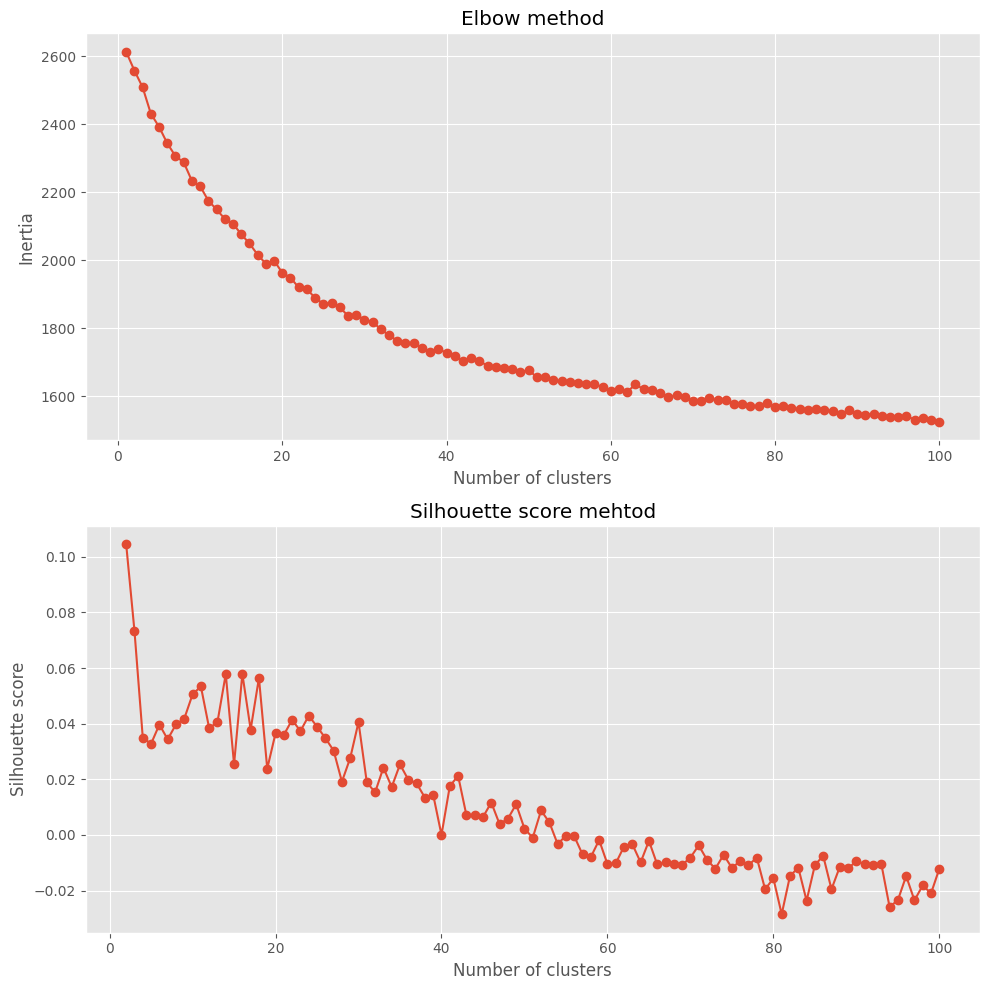

In [7]:
# visualize results

plt.figure( figsize=(10, 10) )

plt.subplot(2, 1, 1)
plt.plot( num_clusters, inertias, marker='o' )
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(2, 1, 2)
plt.plot( num_clusters[1:], silhouette_scores, marker='o' )
plt.title('Silhouette score mehtod')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

plt.tight_layout()
plt.show()

We see that silhouette score mehtod don't give good result, because based on graph the optimal k is 2 but given that we have a dataset with movies, it is unlikely that we can identify only two clusters. But if we see in elbow method graph we can identify break in 35-40 clusters, after those values inertia nearly don't decreas. So it's a good news because in the film industry, there are approximately 30-40 film genres. It means algorithm understood structur of data well.

# Training model

Based on elbow method we are going to use k=35.

In [8]:
# train model

model = KMeans(n_clusters=35)
model.fit(X)

KMeans(n_clusters=35)

In [9]:
# get labels

df['cluster'] = model.labels_

In [10]:
# get centers of clusters

centers = model.cluster_centers_

# Number of film in each cluster

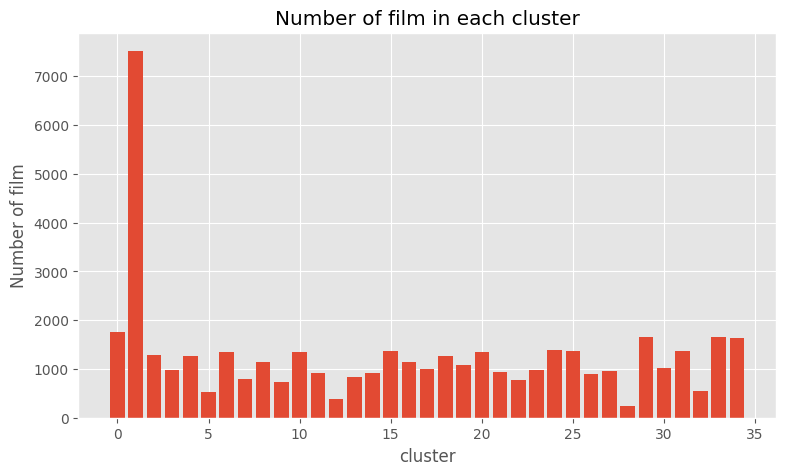

In [11]:
d = df['cluster'].value_counts()
d = d.sort_index()

plt.figure( figsize=(9, 5) )
plt.bar( d.index, d.values )
plt.title('Number of film in each cluster')
plt.xlabel('cluster')
plt.ylabel('Number of film')
plt.show()

We see that clusters have pretty similar number of film except cluster 1 that has much more films and clusters 12 and 28 has oposite much less films.

# Getting the most frequently used words in each cluster

We are going to see in most frequently used words in each cluster. It will help us understand how well the algorithm divided the films into clusters. 

In [12]:
num_clusters = np.arange(0, 35, 1)


for cluster in num_clusters:

    df_cluster = df[ df['cluster'] == cluster ]

    texts = df_cluster['overview'].values.tolist()
    words_dictionary = {}

    for text in texts:
        for word in eval(text):

            if word not in words_dictionary:
                words_dictionary[word] = 0

            words_dictionary[word] += 1

    sorted_words = sorted( words_dictionary.items(), key=lambda x: x[1], reverse=True )
    most_frequently = dict(sorted_words[:3])

    print(f'Cluster: {cluster}. Top 3 frequently words in overiew: {list(most_frequently.keys())}')
    

Cluster: 0. Top 3 frequently words in overiew: ['get', 'back', 'one']
Cluster: 1. Top 3 frequently words in overiew: ['take', 'becom', 'work']
Cluster: 2. Top 3 frequently words in overiew: ['one', 'day', 'night']
Cluster: 3. Top 3 frequently words in overiew: ['documentari', 'film', 'interview']
Cluster: 4. Top 3 frequently words in overiew: ['murder', 'investig', 'killer']
Cluster: 5. Top 3 frequently words in overiew: ['stori', 'tell', 'love']
Cluster: 6. Top 3 frequently words in overiew: ['world', 'one', 'new']
Cluster: 7. Top 3 frequently words in overiew: ['woman', 'husband', 'find']
Cluster: 8. Top 3 frequently words in overiew: ['new', 'york', 'citi']
Cluster: 9. Top 3 frequently words in overiew: ['brother', 'two', 'famili']
Cluster: 10. Top 3 frequently words in overiew: ['love', 'fall', 'young']
Cluster: 11. Top 3 frequently words in overiew: ['girl', 'young', 'one']
Cluster: 12. Top 3 frequently words in overiew: ['year', 'old', 'new']
Cluster: 13. Top 3 frequently words i

We see that algorithm pretty well divids data into clusters because in almost every cluster, the most frequently words indicate the genre that the cluster corresponds to. For example cluster 3 - ['documentari', 'film','interview'] it is a documental films, cluster 4 - ['murder', 'investig', 'killer'] it is crime films, cluster 23 - ['wife', 'husband', 'life'] it is films about married life, etd.

# Visualization of clusters 

For visualization we need to reduce dimensionality to 2d, so we are going to use UMAP. It is a method that keeps forms of clusters better than PCA and is faster than t-sne.

In [13]:
# applying umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)
centers_umap = umap_model.transform(centers)

In [14]:
# dictionary for color of cluster for vizualization

colors = {
    0:  "#FF0000",  1: "#00FF00",  2: "#0000FF",  3: "#FFFF00",  4: "#FF00FF",
    5:  "#00FFFF",  6: "#FFA500",  7: "#800080",  8: "#008000",  9: "#000080",
    10: "#FFC0CB", 11: "#808000", 12: "#FF4500", 13: "#2E8B57", 14: "#4B0082",
    15: "#7FFF00", 16: "#DC143C", 17: "#20B2AA", 18: "#FFD700", 19: "#FF1493",
    20: "#00CED1", 21: "#B22222", 22: "#ADFF2F", 23: "#1E90FF", 24: "#DA70D6",
    25: "#40E0D0", 26: "#FF8C00", 27: "#9932CC", 28: "#00FA9A", 29: "#FF6347",
    30: "#4682B4", 31: "#9ACD32", 32: "#8B0000", 33: "#00BFFF", 34: "#BA55D3"
}

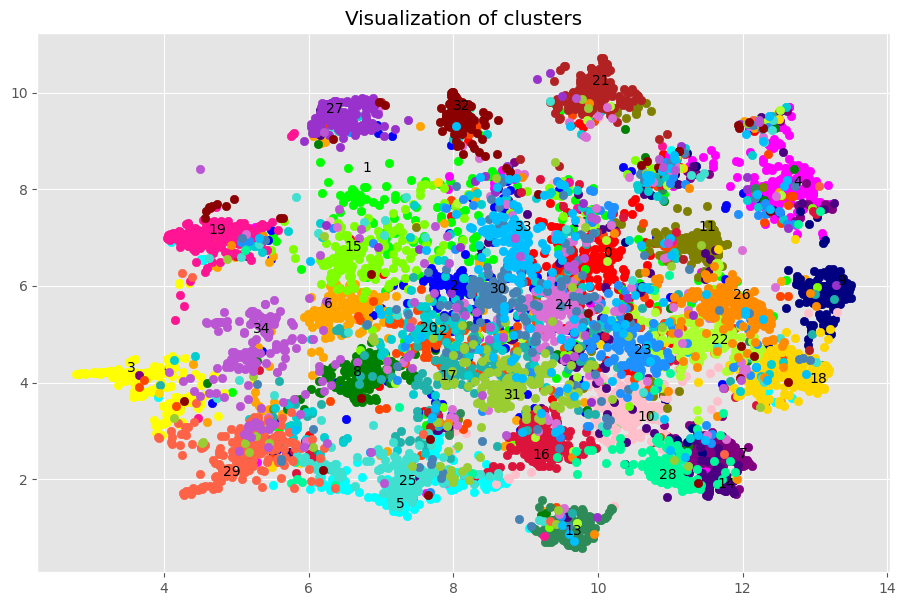

In [ ]:
# visualiztion

plt.figure( figsize=(11, 7) ) 

num_clusters = np.arange(0, 35, 1)

for cluster in num_clusters:

    necessary_data = df[ df['cluster'] == cluster ]
    necessary_indexes = necessary_data.index.tolist()
    sample_indexes = np.random.choice( necessary_indexes, size=200, replace=False )  # get 200 random points from cluster

    necessary_X_umap = X_umap[ sample_indexes ]

    plt.scatter( necessary_X_umap[:, 0], necessary_X_umap[:, 1], color=colors[cluster] )
    plt.text( centers_umap[cluster, 0], centers_umap[cluster, 1], str(cluster) )  # for cluster signature

plt.title('Visualization of clusters')
plt.show()

We see that clusters quite confused and overlapping, which is not surprising but stil have a certain number of data points that form the basis of the cluster and separate it quite clearly from others. 

# Saving model and neseccary data for recomendation system

To create recomendation system application we need to save our model and data about cluster labels of films.

In [18]:
# save kmeans model

joblib.dump( model, '../models/kmeans_model.joblib' )

['../models/kmeans_model.joblib']

In [20]:
# save cluster labels

df[['title','cluster']].to_csv('../data/cluster_labels.csv', index=False)